导包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt

在加载数据之前，需要先准备要应用的转换。准备训练数据以避免过拟合问题是重要的一步

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025)) #定义均值和标准差
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats) # 相当于tt.Normalize(mean=stats[0], std=stats[1])
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])


In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


In [4]:
# for image, label in train_data:
#     print("Image shape: ",image.shape)
#     print("Image tensor: ", image)
#     print("Label: ", label)
#     break

In [5]:
# train_classes_items = dict()

# for train_item in train_data:
#     label = train_data.classes[train_item[1]]
#     if label not in train_classes_items:
#         train_classes_items[label] = 1
#     else:
#         train_classes_items[label] += 1

# train_classes_items

In [6]:
# test_classes_items = dict()
# for test_item in test_data:
#     label = test_data.classes[test_item[1]]
#     if label not in test_classes_items:
#         test_classes_items[label] = 1
#     else:
#         test_classes_items[label] += 1

# test_classes_items

In [7]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

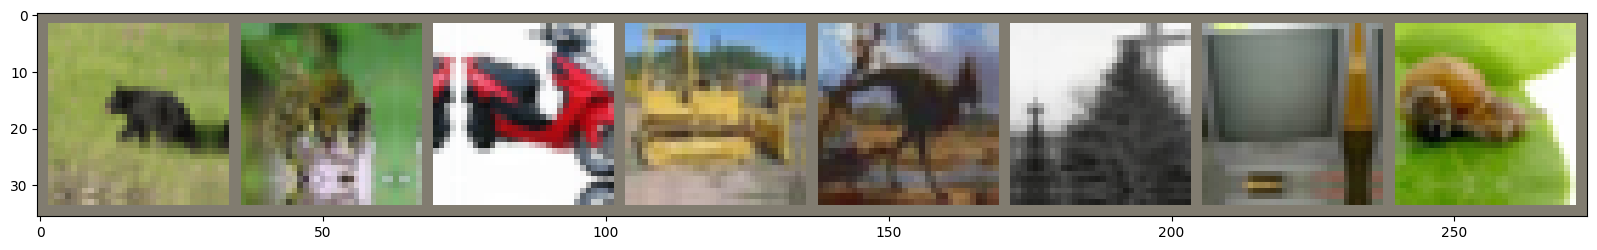

bear                bee                 motorcycle          tractor             dinosaur            pine_tree           television          snail               


In [11]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    # img = img / 2 + 0.5     # 反归一化，这里有点问题，需要是归一化的逆向操作，改成下面的应该才是正确的
    img = img * torch.tensor([0.2011, 0.1987, 0.2025]).view(3, 1, 1) + torch.tensor([0.5074, 0.4867, 0.4411]).view(3, 1, 1)
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))# (C,H,W) 转为 (H,W,C)
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)# 这里修改为新版语法

# print images
imshow(torchvision.utils.make_grid(images))# 8张图片拼接为1张
print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(8)))#打印对应标签，：20s表示空20个字符

In [12]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):# 判定data是否属于列表或元组，如果是，分别移动，就像images = images.to(device)和labels = labels.to(device)这样分别迁移
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)# 如果有gpu，一般会把数据移动到gpu上


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        #这个 __iter__ 方法的作用是：当你用 for batch in train_dl（train_dl 是 ToDeviceLoader 实例）时，会自动执行 __iter__ 方法。
        #它会遍历原始 DataLoader（self.data）中的每个批次，通过 yield 逐个返回迁移到目标设备后的批次数据（图像和标签）。
        for batch in self.data:#这里的self.data就相当于原来的Dataloader，batch在创建Dataloader时被定义好了
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [13]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device) # 相当于给原dataloader添加新功能，具备自动迁移数据到指定设备的功能
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [15]:
# 计算模型预测结果准确率，actual代表真实类别索引
# predicted的形状为(batch_size, num_classes)，即批量大小*类别数，每一列代表每个种类的预测分数
# _, predictions代表只接收函数返回的第二个值，predictions会接收batch_size个预测的类别索引
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))# .item用于将单元素张量转换为python类型值

In [16]:
class BaseModel(nn.Module):
    # 定义单批次训练的计算步骤，返回当前批次的损失值
    def training_step(self,batch):
        images, labels = batch
        out = self(images)# 得到预测输出
        loss = F.cross_entropy(out,labels)# 计算交叉熵损失
        return loss
        
    # 定义单批次验证的计算步骤，返回当前批次的验证损失和准确率
    # 返回一个字典 {"val_loss": loss.detach(), "val_acc": acc}
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        #self是当前模型实例（继承自 nn.Module），self(images)等价于 self.forward(images)。
        #这是 PyTorch 的语法糖：直接对实例调用 ()会触发 __call__方法，而 nn.Module的 __call__内部会调用 forward()
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}# loss.detach() 切断损失张量与计算图的连接（验证阶段不需要求导，节省内存）
    
    #在整个验证 epoch 结束后，汇总所有批次的验证结果，计算平均损失和平均准确率
    # 输入 outputs 是一个列表，包含每个验证批次的 validation_step 返回的字典（即 [{"val_loss": ..., "val_acc": ...}, ...]）
    # 从 outputs 中提取所有批次的损失值 batch_losses，用 torch.stack(batch_losses).mean() 计算整个 epoch 的平均损失
    # 返回汇总后的字典 {"val_loss": loss.item(), "val_acc": acc.item()}
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        # [loss["val_loss"] for loss in outputs]是一个Python列表推导式（List Comprehension）
        # 它的作用是从一个包含多个字典的列表outputs中，提取每个字典中键为 "val_loss"对应的值，最终生成一个新的列表
        loss = torch.stack(batch_losses).mean()# 将列表转为张量后求平均
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

搭建网络

In [17]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)# 语法糖：nn.Sequential(*layers)等价于将列表中的层逐个传入 nn.Sequential()

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)# first_layers是一个列表，所以可以这么写，用于修改步长
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()# 继承父类，必须调用
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)# 卷积 shortcut 连接（用 1x1 卷积调整通道 / 尺寸，与残差块输出匹配）
        
        self.conv2 = block(64,[64,256],3,1,conv=True)# 带下采样的残差块（conv=True，通过第一个卷积层的stride控制下采样）
        self.ident2 = block(256,[64,256],3,1)# 恒等残差块（无下采样，输入输出尺寸 / 通道一致）

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):# 这里的inputs就是out = self(images)中的images
        out = self.stg1(inputs)# inputs形状：(batch_size, in_channels, height, width)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out
        

In [18]:
model = ResNet(3,100)# 传入输入通道和需要分类的类别数

In [19]:
model = to_device(model, device)# 不是列表或者元组，相当于直接调用model = model.to(device)

In [20]:
@torch.no_grad()# 装饰器，仅作用于被装饰的函数，禁用 PyTorch 的自动求导机制
def evaluate(model,test_dl):
    model.eval()#切换到评估模式
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [21]:
# 获取优化器当前的学习率（lr）
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()# 清空GPU缓存，避免内存溢出
    
    history = []# 存储每轮训练的指标（损失、准确率等），用于后续分析
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)# 初始化优化器：传入模型参数、最大学习率、权重衰减
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))# 初始化学习率调度器：根据训练轮数和每轮步数（训练集批次数）调整学习率
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:#这里触发yeild，将数据迁移到指定设备
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:# 梯度裁剪（可选）：如果梯度超过阈值，裁剪到阈值内（防止梯度爆炸）
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()# 优化器更新参数：根据梯度调整模型权重
            optimizer.zero_grad()# 清空梯度：避免下一批次梯度累积
            
            scheduler.step()# 学习率调度器更新：按策略调整当前学习率（如OneCycleLR动态调整）
            lrs.append(get_lr(optimizer))# 记录当前学习率
            
        result = evaluate(model, test_dl)# 得到val_loss和val_acc
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)# 打印输出
        history.append(result)
        
    return history
            

In [22]:
epochs = 10
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [23]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00028, train_loss: 3.8768, val_loss: 3.9774, val_acc: 0.1081
Epoch [1], last_lr: 0.00076, train_loss: 3.2625, val_loss: 3.3370, val_acc: 0.2066
Epoch [2], last_lr: 0.00100, train_loss: 2.8702, val_loss: 2.9712, val_acc: 0.2633
Epoch [3], last_lr: 0.00095, train_loss: 2.4282, val_loss: 2.6779, val_acc: 0.3106
Epoch [4], last_lr: 0.00081, train_loss: 2.0887, val_loss: 2.3754, val_acc: 0.3781
Epoch [5], last_lr: 0.00061, train_loss: 1.8074, val_loss: 2.1780, val_acc: 0.4300
Epoch [6], last_lr: 0.00039, train_loss: 1.5724, val_loss: 1.9635, val_acc: 0.4706
Epoch [7], last_lr: 0.00019, train_loss: 1.3470, val_loss: 1.7566, val_acc: 0.5250
Epoch [8], last_lr: 0.00005, train_loss: 1.1256, val_loss: 1.5295, val_acc: 0.5757
Epoch [9], last_lr: 0.00000, train_loss: 0.9948, val_loss: 1.4815, val_acc: 0.5880
CPU times: user 1min 54s, sys: 55.3 s, total: 2min 49s
Wall time: 2min 45s


[{'val_loss': 3.97737455368042,
  'val_acc': 0.1080894023180008,
  'train_loss': 3.8768227100372314,
  'lrs': [4.000172446944484e-05,
   4.000689786538868e-05,
   4.001552015065889e-05,
   4.0027591263302196e-05,
   4.004311111658384e-05,
   4.0062079598989506e-05,
   4.00844965742249e-05,
   4.0110361881217694e-05,
   4.013967533411818e-05,
   4.017243672230068e-05,
   4.020864581036506e-05,
   4.024830233813879e-05,
   4.029140602067804e-05,
   4.033795654827027e-05,
   4.038795358643672e-05,
   4.044139677593416e-05,
   4.049828573275769e-05,
   4.05586200481438e-05,
   4.062239928857294e-05,
   4.068962299577281e-05,
   4.0760290686721475e-05,
   4.083440185365149e-05,
   4.0911955964052305e-05,
   4.099295246067533e-05,
   4.1077390761537426e-05,
   4.116527025992481e-05,
   4.125659032439802e-05,
   4.135135029879574e-05,
   4.14495495022403e-05,
   4.1551187229141935e-05,
   4.165626274920428e-05,
   4.176477530742906e-05,
   4.187672412412247e-05,
   4.1992108394899746e-05,
   

In [20]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

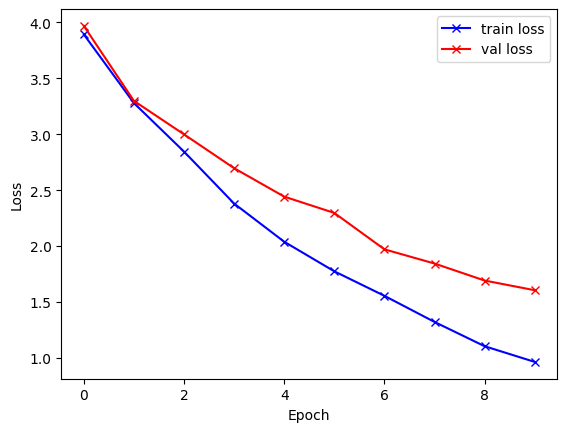

In [21]:
plot_loss(history)

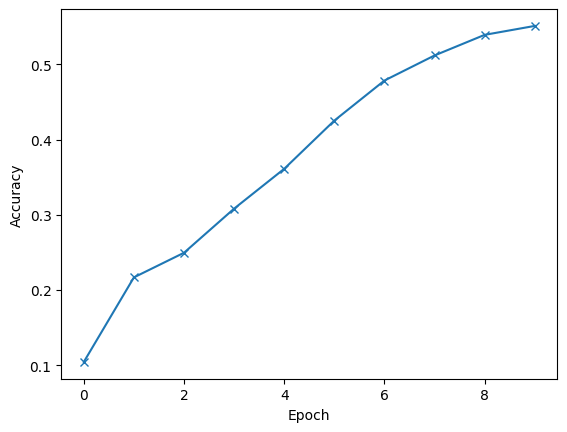

In [22]:
plot_acc(history)

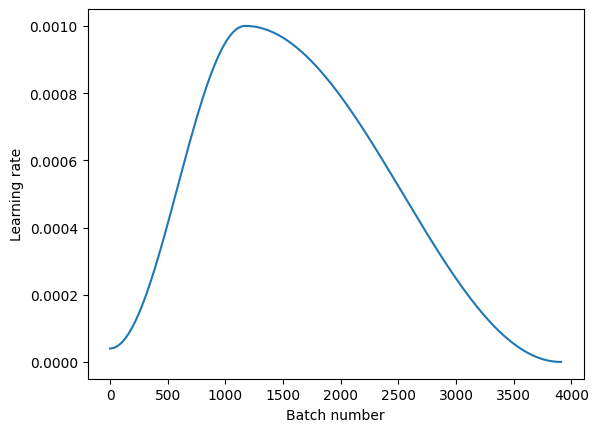

In [23]:
plot_lrs(history)

In [24]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: mountain , Predicted: otter


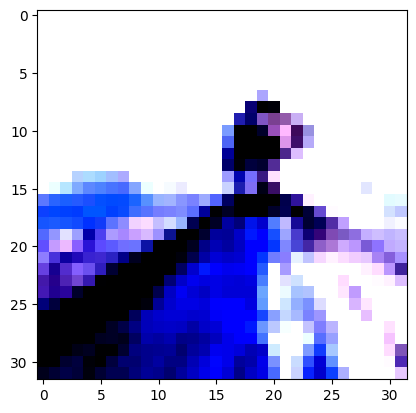

In [25]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: wardrobe , Predicted: wardrobe


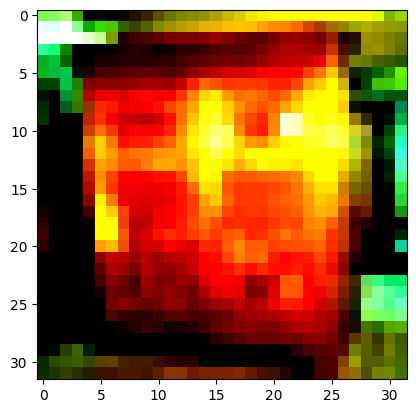

In [26]:
img, label = test_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

In [27]:
torch.save(model.state_dict(), 'cifar100-resnet-project.pth')